In [13]:
# imports
import csv
import tensorflow as tf
import keras
import keras.backend.tensorflow_backend as KTF
import cv2
import numpy as np



In [14]:
speed = []
throttle = []
left = []
center = []
right = []
steering = []

# Load driving log:
with open('data/driving_log.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        speed.append(float(row['speed']))
        throttle.append(float(row['throttle']))
        left.append(row['left'])
        center.append(row['center'])
        right.append(row['right'])
        steering.append(float(row['steering']))


In [15]:
# Make sure the data is loaded correctly
assert len(speed) == len(throttle) == len(left) == len(center) == len(right) == len(steering)
print(len(speed))

8036


In [16]:
# Preprocessing
def preprocess(image, width=200, height=66):
    processed = image[60:130, 0:320]
    processed = cv2.resize(processed, (width, height), interpolation = cv2.INTER_CUBIC)
    return processed

In [17]:
# Build Keras model according to the NVIDIA paper
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization

batch_size = 100
epochs = 5
model = Sequential()
model.add(BatchNormalization(input_shape=(66, 200, 3), axis=1))
model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample = (2,2), input_shape=(66,200,3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample = (2,2)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample = (2,2)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample = (1,1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample = (1,1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Dense(1))
model.summary()

# Configures the learning process and metrics
model.compile('adam', 'mean_squared_error', ['accuracy'])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 66, 200, 3)    264         batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 31, 98, 24)    0           activation_1[0][0]               
___________________________________________________________________________________________

-0.4395315 0.0 0.4349326
(160, 320, 3)


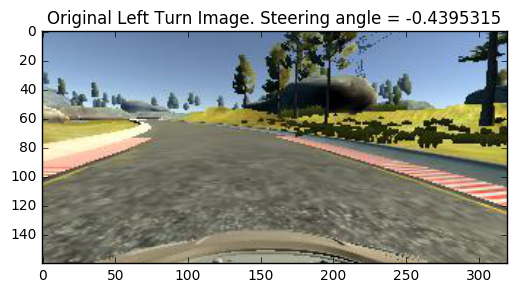

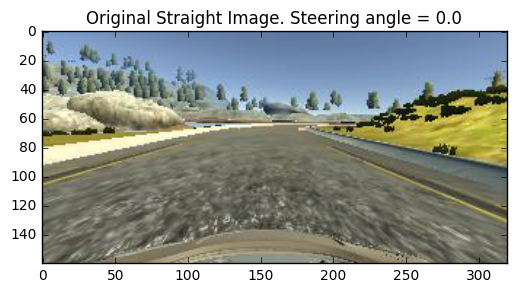

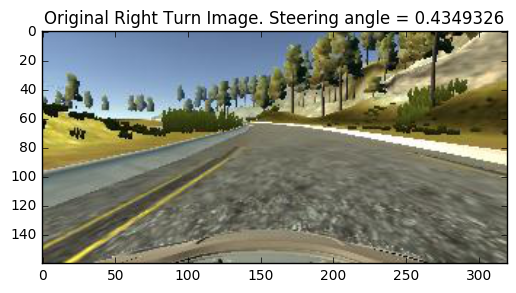

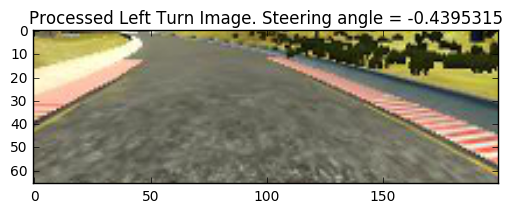

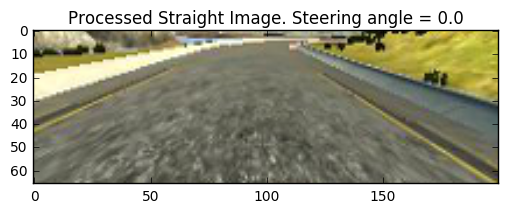

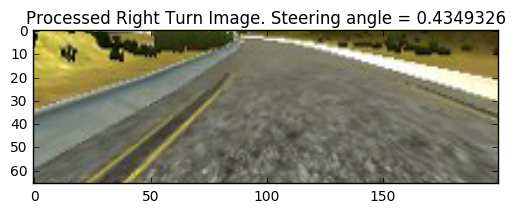

In [18]:
# Test model with a few sample images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Find 3 test images: big left turn, straight run, and big right turn
left_turn_image_idx = 0
straight_image_idx = 0
right_turn_image_idx = 0

for i in range(len(steering)):
    angle = steering[i]
    if angle < -0.4:
        left_turn_image_idx = i
    elif angle == 0:
        straight_image_idx = i
    elif angle > 0.4:
        right_turn_image_idx = i
        
print(steering[left_turn_image_idx], steering[straight_image_idx], steering[right_turn_image_idx])

left_turn_image_c=mpimg.imread("data/"+center[left_turn_image_idx].strip())

print(left_turn_image_c.shape)


plt.imshow(left_turn_image_c)
plt.title("Original Left Turn Image. Steering angle = {}".format(steering[left_turn_image_idx]))
plt.show()

straight_image_c=mpimg.imread("data/"+center[straight_image_idx].strip())
plt.imshow(straight_image_c)
plt.title("Original Straight Image. Steering angle = {}".format(steering[straight_image_idx]))
plt.show()

right_turn_image_c=mpimg.imread("data/"+center[right_turn_image_idx].strip())
plt.imshow(right_turn_image_c)
plt.title("Original Right Turn Image. Steering angle = {}".format(steering[right_turn_image_idx]))
plt.show()

left_turn_image_c_processed = preprocess(left_turn_image_c)
plt.imshow(left_turn_image_c_processed)
plt.title("Processed Left Turn Image. Steering angle = {}".format(steering[left_turn_image_idx]))
plt.show()

straight_image_c_processed = preprocess(straight_image_c)
plt.imshow(straight_image_c_processed)
plt.title("Processed Straight Image. Steering angle = {}".format(steering[straight_image_idx]))
plt.show()

right_turn_image_c_processed = preprocess(right_turn_image_c)
plt.imshow(right_turn_image_c_processed)
plt.title("Processed Right Turn Image. Steering angle = {}".format(steering[right_turn_image_idx]))
plt.show()

In [19]:
# Run test images through model

x_train_data = np.array([left_turn_image_c_processed, straight_image_c_processed, right_turn_image_c_processed])
Y_train_data = np.array([steering[left_turn_image_idx], steering[straight_image_idx], steering[right_turn_image_idx]])

print((3,) + x_train_data[0].shape)
# print(Y_train_data)

history = model.fit(x_train_data, Y_train_data, batch_size=1, nb_epoch=5)

# Calculate test score
test_score = model.evaluate(x_train_data, Y_train_data)

print(test_score)
print(model.predict(x_train_data))

(3, 66, 200, 3)
Epoch 1/5
3/3 [==============================] - 0s - loss: 0.1305 - acc: 0.3333     
Epoch 2/5
3/3 [==============================] - 0s - loss: 0.1312 - acc: 0.3333     
Epoch 3/5
3/3 [==============================] - 0s - loss: 0.1256 - acc: 0.3333         
Epoch 4/5
3/3 [==============================] - 0s - loss: 0.1330 - acc: 0.3333         
Epoch 5/5
3/3 [==============================] - 0s
[0.14405073225498199, 0.3333333432674408]
[[ 0.13019776]
 [ 0.14346929]
 [ 0.14001347]]


In [21]:
import matplotlib.image as mpimg

# Generate additional data using left, right and flipped images
# 1) Choose a random index from all existing training images (~8000)
# 2) Generate 6 images and their corresponding steering angles using the left and right camera images with a steering correction,
# as well as the symmetries of the 3 images with respect to the vertical axis
def generate_data():
    while True:
        idx = randint(0, len(center)-1)

        cimg = preprocess(mpimg.imread("data/"+center[idx].strip()))
        limg = preprocess(mpimg.imread("data/"+left[idx].strip()))
        rimg = preprocess(mpimg.imread("data/"+right[idx].strip()))
        cflipped = cv2.flip(cimg,1)
        lflipped = cv2.flip(limg,1)
        rflipped = cv2.flip(rimg,1)

        generated_images = np.array([cimg, limg, rimg, cflipped, lflipped, rflipped])

        steering_correction = 0.25

        csteering = steering[idx]
        lsteering = csteering + steering_correction
        rsteering = csteering - steering_correction
        csflipped = -csteering
        lsflipped = -lsteering
        rsflipped = -rsteering

        generated_steerings = np.array([csteering, lsteering, rsteering, csflipped, lsflipped, rsflipped])

        yield generated_images, generated_steerings 

In [22]:
# Run test images through model
from random import randint

x_train_data = np.array([left_turn_image_c_processed, straight_image_c_processed, right_turn_image_c_processed])
Y_train_data = np.array([steering[left_turn_image_idx], steering[straight_image_idx], steering[right_turn_image_idx]])

model.fit_generator(generate_data(), 
                    samples_per_epoch=48000, # approximately len(center)*6, which should cover most images in training set
                    nb_epoch=5,
                    verbose=2)

# Calculate test score
test_score = model.evaluate(x_train_data, Y_train_data)
print(test_score)
# The test score is only to give an idea about the accuracy.
# The performance of the model can only be shown in the simulator

print(model.predict(x_train_data))

Epoch 1/5
402s - loss: 0.0284 - acc: 0.1789
Epoch 2/5
447s - loss: 0.0244 - acc: 0.1834
Epoch 3/5
383s - loss: 0.0241 - acc: 0.1789
Epoch 4/5
355s - loss: 0.0236 - acc: 0.1819
Epoch 5/5
367s - loss: 0.0216 - acc: 0.1835
3/3 [==============================] - 0s
[0.039480343461036682, 0.3333333432674408]
[[-0.23482731]
 [-0.05633043]
 [ 0.16407451]]


In [23]:
# Save model and weights
import json

json_str = model.to_json()
with open('model.json','w') as f:
    json.dump(json_str, f)

model.save_weights('model.h5')